In [22]:
import mne
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [4]:


tmin, tmax = 2.0, 6.0
fmin, fmax = 8., 30.



In [5]:

def load_gdf_and_labels(gdf_file, mat_file):
    raw = mne.io.read_raw_gdf(gdf_file, preload=True)
    raw.pick_types(eeg=True)
    raw.filter(fmin, fmax, fir_design='firwin')

    y = loadmat(mat_file)['classlabel'].flatten() - 1  # map 1–4 → 0–3

    # Extract events from annotations
    events, event_id = mne.events_from_annotations(raw)
    
    # Motor imagery events (trial start = 768)
    mi_events_idx = np.where(events[:, 2] == event_id['768'])[0]
    mi_events = np.array([[events[i, 0], 0, 0] for i in mi_events_idx])

    epochs = mne.Epochs(raw, mi_events, tmin=tmin, tmax=tmax,
                        baseline=None, preload=True)
    X = epochs.get_data()
    return raw, epochs, X, y



In [7]:
# Training
raw_train, epochs_train, X_train, y_train = load_gdf_and_labels("C:\\Users\\Luchitha\\Documents\\BCI\\BCI_IV\\dataset\\A01T.gdf", "C:\\Users\\Luchitha\\Documents\\BCI\\BCI_IV\\true_labels\\A01T.mat")

# Evaluation
raw_eval, epochs_eval, X_eval, y_eval = load_gdf_and_labels("C:\\Users\\Luchitha\\Documents\\BCI\\BCI_IV\\dataset\\A01E.gdf", "C:\\Users\\Luchitha\\Documents\\BCI\\BCI_IV\\true_labels\\A01E.mat")




Extracting GDF parameters from C:\Users\Luchitha\Documents\BCI\BCI_IV\dataset\A01T.gdf...
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\Users\Luchitha\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 origin

C:\Users\Luchitha\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('783')]
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped


In [8]:
# TRAIN CSP + LDA

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
pipeline.fit(X_train, y_train)




Computing rank from data with rank=None
    Using tolerance 6.7e-05 (2.2e-16 eps * 25 dim * 1.2e+10  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('CSP', ...), ('LDA', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,n_components,4
,reg,None
,log,True
,cov_est,'concat'
,transform_into,'average_power'
,norm_trace,False
,cov_method_params,None


In [9]:
y_pred = pipeline.predict(X_eval)



acc = accuracy_score(y_eval, y_pred)
cm = confusion_matrix(y_eval, y_pred)
report = classification_report(y_eval, y_pred, target_names=['Left', 'Right', 'Feet', 'Tongue'])

print("Evaluation Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Evaluation Accuracy: 0.6979166666666666
Confusion Matrix:
 [[59  4  4  5]
 [15 48  9  0]
 [ 2  0 36 34]
 [ 2  0 12 58]]
Classification Report:
               precision    recall  f1-score   support

        Left       0.76      0.82      0.79        72
       Right       0.92      0.67      0.77        72
        Feet       0.59      0.50      0.54        72
      Tongue       0.60      0.81      0.69        72

    accuracy                           0.70       288
   macro avg       0.72      0.70      0.70       288
weighted avg       0.72      0.70      0.70       288



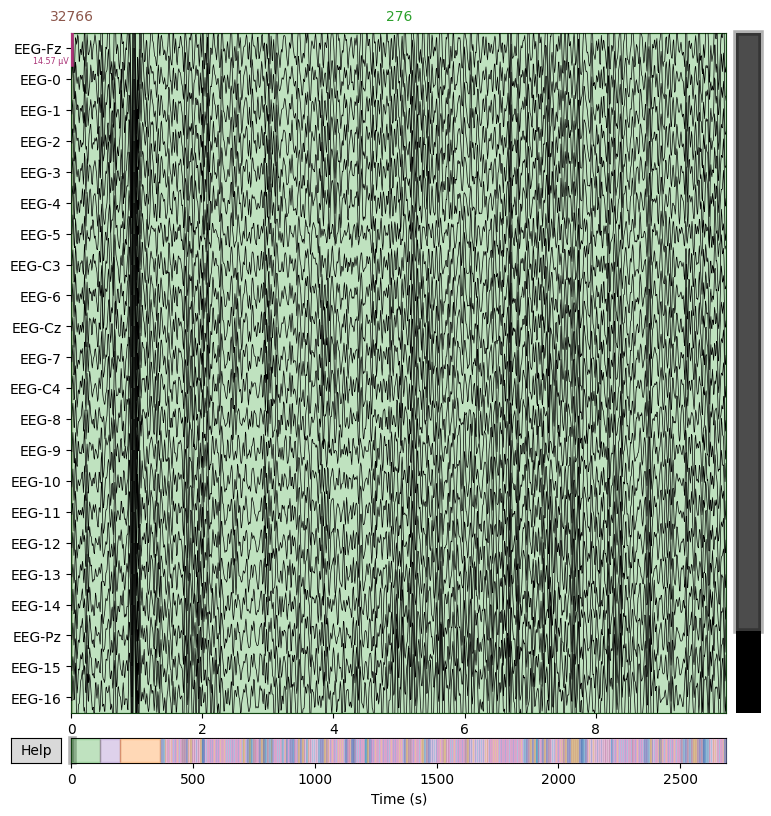

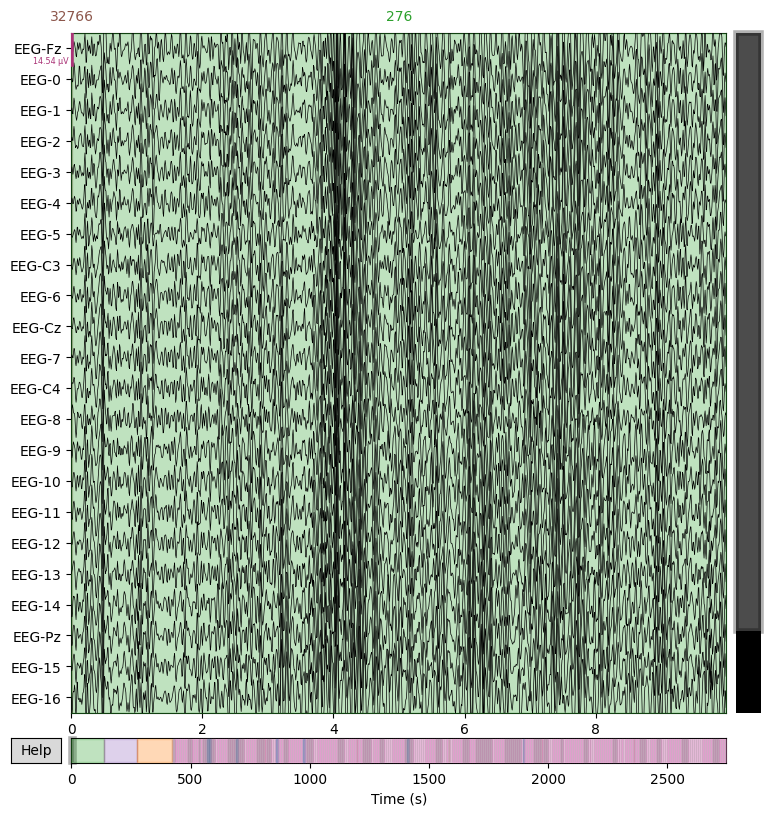

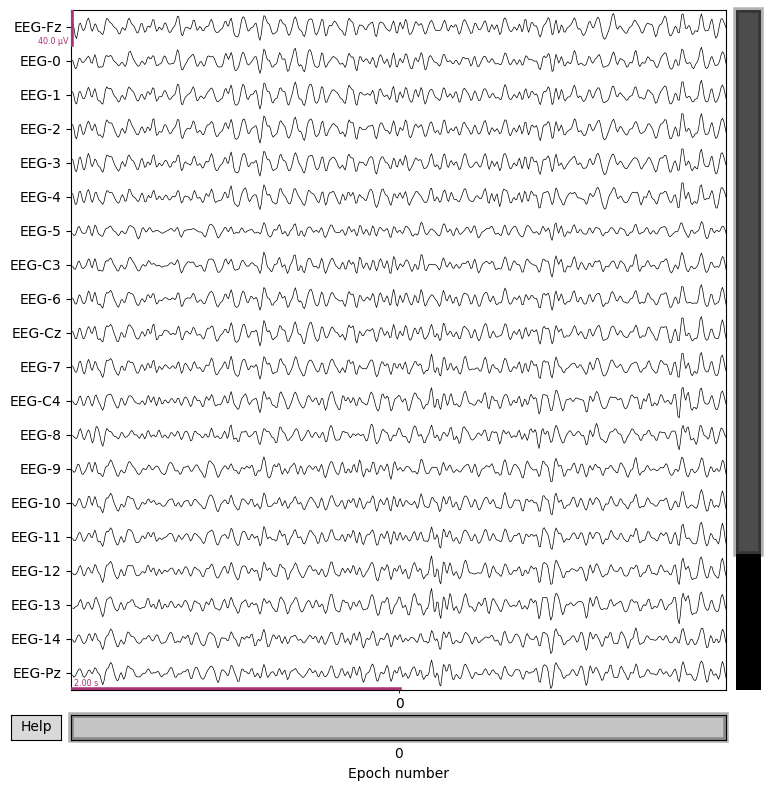

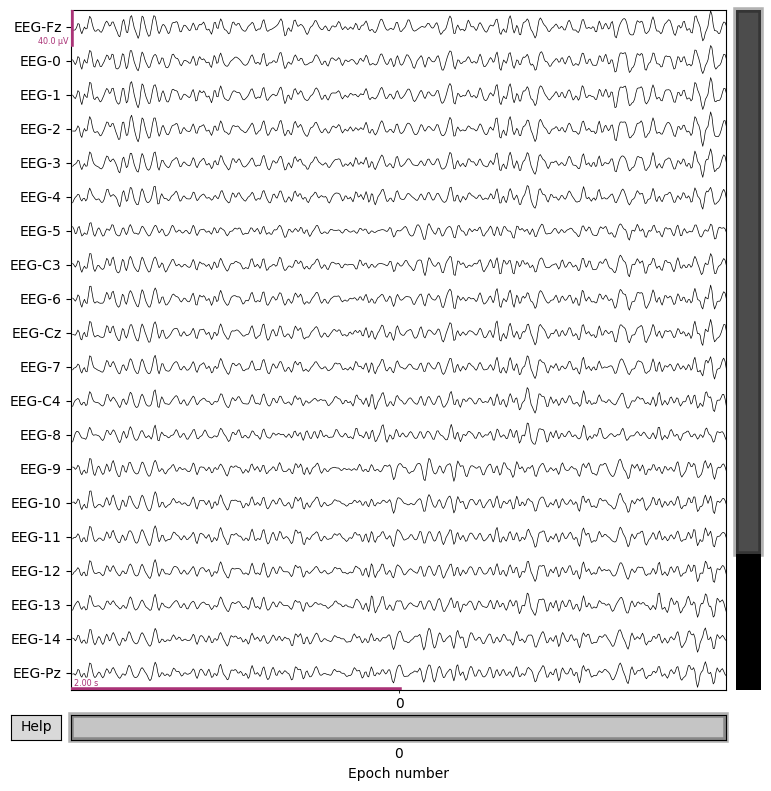

C:\Users\Luchitha\AppData\Local\Temp\ipykernel_7796\3492396699.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig_train = evoked_train.plot(time_unit='s', spatial_colors=True)


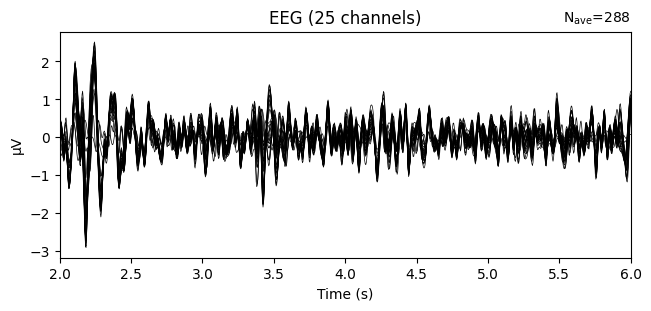

C:\Users\Luchitha\AppData\Local\Temp\ipykernel_7796\3492396699.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig_eval = evoked_eval.plot(time_unit='s', spatial_colors=True)


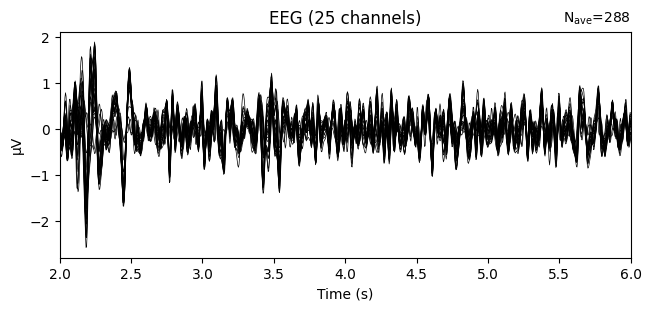

Text(0.5, 0.98, 'ERP Evaluation')

In [16]:
# 1. Raw EEG scrollable
raw_train.plot(start=0, duration=10, n_channels=22, scalings='auto', title='Training EEG')
raw_eval.plot(start=0, duration=10, n_channels=22, scalings='auto', title='Evaluation EEG')

# 2. Single trial plot
epochs_train[0].plot(title='First Training Trial')
epochs_eval[0].plot(title='First Evaluation Trial')

# 3. ERP / average
evoked_train = epochs_train.average()
evoked_eval = epochs_eval.average()

fig_train = evoked_train.plot(time_unit='s', spatial_colors=True)
fig_train.suptitle('ERP Training')

fig_eval = evoked_eval.plot(time_unit='s', spatial_colors=True)
fig_eval.suptitle('ERP Evaluation')




NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\Luchitha\Documents\BCI\BCI_IV\venv\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


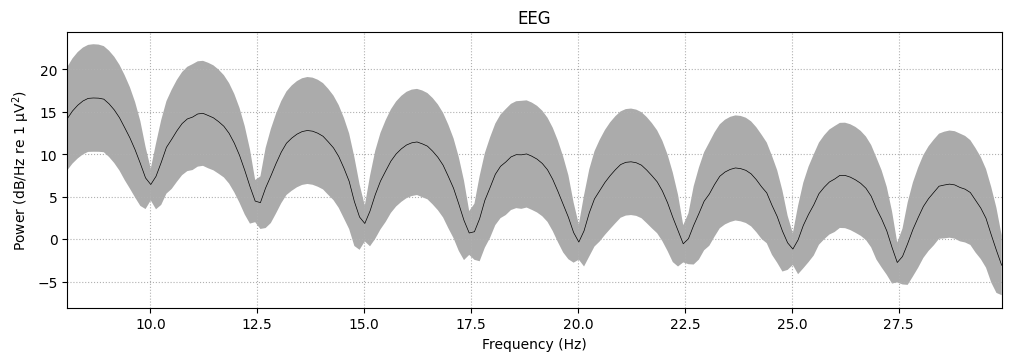

In [24]:


raw_train.plot_psd(fmin=fmin, fmax=fmax, average=True)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\Luchitha\Documents\BCI\BCI_IV\venv\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


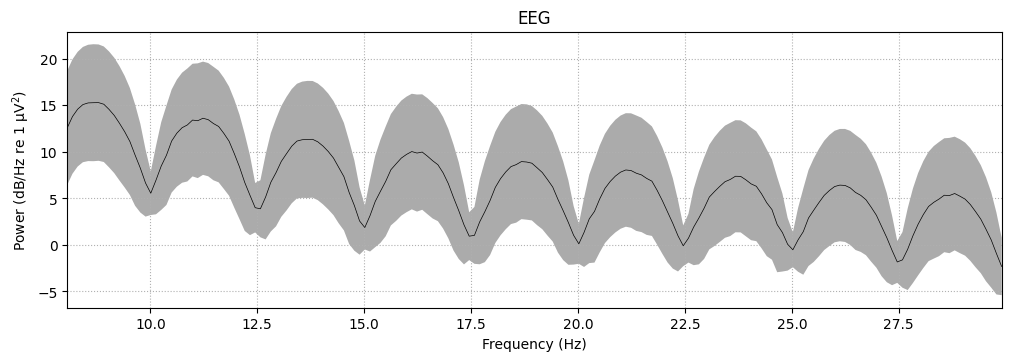

In [25]:
raw_eval.plot_psd(fmin=fmin, fmax=fmax, average=True)

In [29]:
print(epochs_train.info['ch_names'])



['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']


In [ ]:
rename_dict = {
    'EEG-Fz': 'Fz',
    'EEG-0': 'FC1',
    'EEG-1': 'FC2',
    'EEG-2': 'C3',
    'EEG-3': 'Cz',
    'EEG-4': 'C4',
    'EEG-5': 'CP1',
    'EEG-C3': 'CP2',
    'EEG-6': 'FC5',
    'EEG-Cz': 'FC6',
    'EEG-7': 'CP5',
    'EEG-C4': 'CP6',
    'EEG-8': 'F3',
    'EEG-9': 'F4',
    'EEG-10': 'P3',
    'EEG-11': 'P4',
    'EEG-12': 'O1',
    'EEG-13': 'O2',
    'EEG-14': 'F7',
    'EEG-Pz': 'F8',
    'EEG-15': 'T7',
    'EEG-16': 'T8',
    'EOG-left': 'EOG-left',
    'EOG-central': 'EOG-central',
    'EOG-right': 'EOG-right'
}

In [34]:
epochs_train.rename_channels(rename_dict)
epochs_eval.rename_channels(rename_dict)

montage = mne.channels.make_standard_montage('standard_1020')
epochs_train.set_montage(montage)
epochs_eval.set_montage(montage)


ValueError: Invalid channel name(s) {'EEG-F3', 'EEG-T7', 'EEG-CP6', 'EEG-O2', 'EEG-O1', 'EEG-FC5', 'EEG-F7', 'EEG-FC6', 'EEG-F4', 'EEG-CP1', 'EEG-FC2', 'EEG-CP5', 'EEG-FC1', 'EEG-F8', 'EEG-P3', 'EEG-P4', 'EEG-CP2', 'EEG-T8'} are not present in info